# Emotion Detection 

#Importing Libraries

In [6]:
import matplotlib.pyplot as plt
from glob import glob 
import cv2
import random 
import os 
%matplotlib inline



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model 



In [8]:
from IPython.display import SVG, Image
import tensorflow as tf 
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.16.1


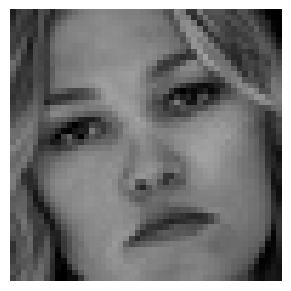

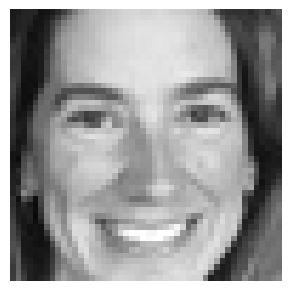

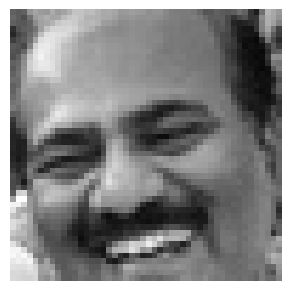

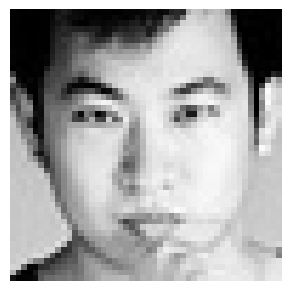

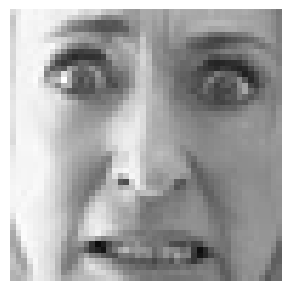

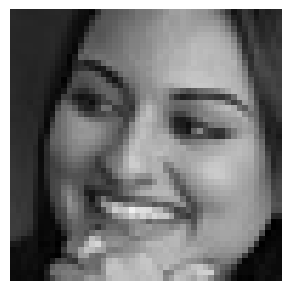

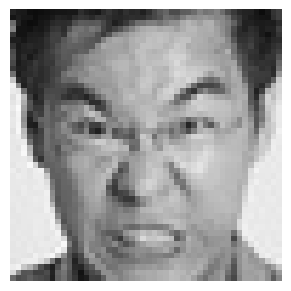

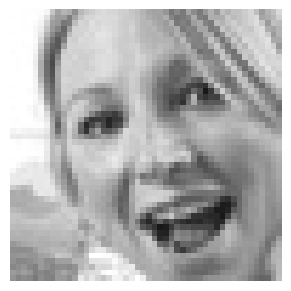

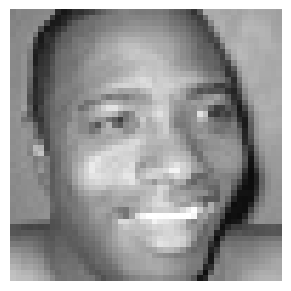

In [9]:
images =glob("train/**/**")
for i in range(9): 
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data For Training**

In [10]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/" ,
                                                 target_size=(img_size, img_size),
                                                 color_mode= "grayscale", 
                                                 batch_size=batch_size, 
                                                 class_mode="categorical", 
                                                 shuffle =True)
datagen_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/" ,
                                                 target_size=(img_size, img_size),
                                                 color_mode= "grayscale", 
                                                 batch_size=batch_size, 
                                                 class_mode="categorical", 
                                                 shuffle =True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
def Convulation(input_tensor, filters, kernel_size):
    x=Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    
    return x
    

In [12]:
def Dense_f(input_tensor, nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

In [13]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convulation(inputs, 32,(3,3))
    conv_2=Convulation(inputs, 64,(5,3))
    conv_3=Convulation(inputs, 128,(3,3))
    
    flatten=Flatten()(conv_3)
    
    dense_1=Dense_f(flatten, 256)
    
    output= Dense(7,activation="softmax")(dense_1)
    model=Model(inputs=[inputs], outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'], optimizer = "adam" , metrics=['accuracy'])
    
    return model

In [14]:
model=model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the Model**

In [15]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint=ModelCheckpoint("model_weights.weights.h5", monitor="val_accuracy", save_weights_only=True, mode="max", verbose=1)
callbacks=[checkpoint]

# Training the Model

**Next steps take time to complete**

In [16]:
history=model.fit(
x=train_generator, 
steps_per_epoch=steps_per_epoch, 
epochs=epochs, 
validation_data=validation_generator,
validation_steps=validation_steps, 
callbacks=callbacks)

Epoch 1/15


C:\Users\Taarini\Documents\Python Scripts\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3355 - loss: 1.8179
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 804s 2s/step - accuracy: 0.3356 - loss: 1.8175 - val_accuracy: 0.3149 - val_loss: 2.0424
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:30 1s/step - accuracy: 0.5156 - loss: 1.2554
Epoch 2: saving model to model_weights.weights.h5


C:\Users\Taarini\Documents\Python Scripts\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5156 - loss: 1.2554 - val_accuracy: 0.5000 - val_loss: 1.2592
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4872 - loss: 1.3510
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.4872 - loss: 1.3510 - val_accuracy: 0.4219 - val_loss: 1.5626
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 9:40 1s/step - accuracy: 0.4375 - loss: 1.4623
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 1.4623 - val_accuracy: 0.3000 - val_loss: 1.7171
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5586 - loss: 1.1819
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.5585 - loss: 1.1819 - val_accuracy: 0.3097 - val_loss: 1.8158
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:40 762ms/step - accuracy: 0.5469 - loss: 1.2179
Epoch 6: saving model to model_we

In [17]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.4139 - loss: 1.8903


[1.9101362228393555, 0.4196154773235321]

**Plotting Loss**

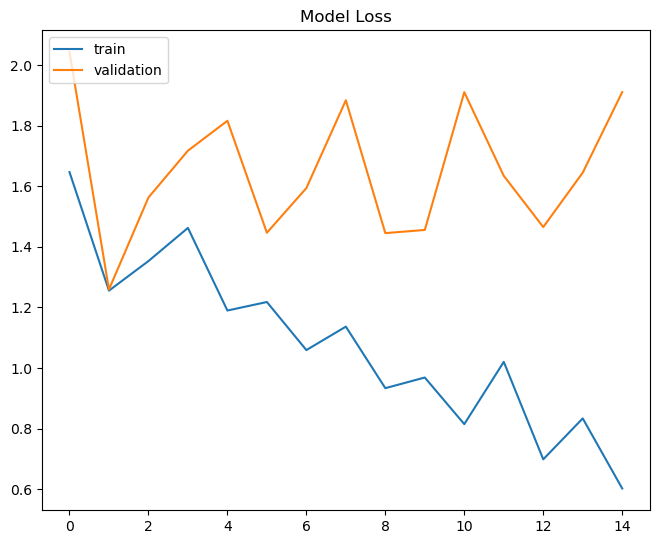

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

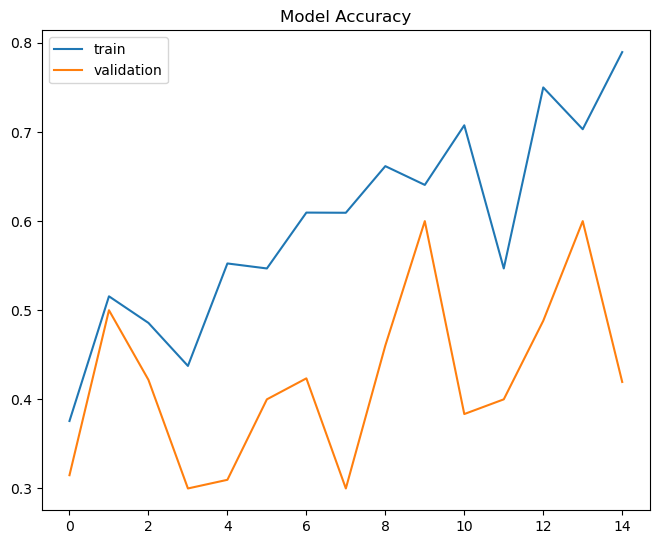

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving the Model**

In [20]:
model_json=model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)